In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv("data/food_crises_month_imputed.csv") # Read data into DataFrame
df.set_index(["datetime", "district"], inplace=True) # Set index

In [3]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

In [4]:

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.reset_index(inplace=True)
df.set_index('datetime', inplace=True)
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df.index = pd.to_datetime(df.index)
df

,district,country,district_code,centx,centy,year_month,year,month,ipc,ha,...,date,province,administrative_region,quarters,count_violence_lag_3,ndvi_anom_lag_3,food_price_idx_lag_3,ipc_lag_1,ipc_lag_2,ipc_lag_3
datetime,,,,,,,,,,,,,,,,,,,,,
2009-07-01,Bor,South Sudan,74,32.00486,6.465644,2009_07,2009,7,2.0,NaN,...,2009-07-01,Greater Upper Nile,Greater Upper Nile,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Terekeka,South Sudan,97,31.32576,5.662623,2009_07,2009,7,1.0,NaN,...,2009-07-01,Equatoria,Equatoria,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Duk,South Sudan,116,31.18647,7.617574,2009_07,2009,7,2.0,NaN,...,2009-07-01,Greater Upper Nile,Greater Upper Nile,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Tonj East,South Sudan,117,29.28494,7.847276,2009_07,2009,7,1.0,NaN,...,2009-07-01,Bahr El Ghazal,Bahr El Ghazal,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Fashoda,South Sudan,147,31.84424,9.980295,2009_07,2009,7,1.0,NaN,...,2009-07-01,Greater Upper Nile,Greater Upper Nile,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,Koch,South Sudan,127,29.85742,8.633903,2020_02,2020,2,3.0,0.0,...,2020-02-01,Greater Upper Nile,Greater Upper Nile,2020Q1,0.166667,111.294617,2.234340,3.0,3.0,3.0
2020-02-01,Aweil Center,South Sudan,128,26.89562,8.417934,2020_02,2020,2,3.0,1.0,...,2020-02-01,Bahr El Ghazal,Bahr El Ghazal,2020Q1,0.000000,105.971917,3.064545,3.0,3.0,3.0
2020-02-01,Gogrial East,South Sudan,129,28.58906,8.597443,2020_02,2020,2,3.0,0.0,...,2020-02-01,Bahr El Ghazal,Bahr El Ghazal,2020Q1,0.166667,106.954817,2.734335,3.0,2.0,2.0


In [5]:
news_df = pd.read_csv("data/articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["datetime"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [6]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["datetime"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

# country wide news features
news_features = create_news_features(
    ["hunger", 'refugees', 'conflict', 'humanitarian', 'corruption', 'terrorism', 'nature', 'oil'])
news_features.dropna(how='all', inplace=True)
news_features.index = pd.to_datetime(news_features.index)

news_features

,hunger,refugees,conflict,humanitarian,corruption,terrorism,nature,oil
datetime,,,,,,,,
2011-11-01,0.028705,0.003101,1.978309e-02,0.004841,0.037745,0.013654,2.628419e-02,0.018686
2011-12-01,0.021502,0.003101,8.835235e-03,0.006714,0.032703,0.013654,2.095432e-02,0.018686
2012-01-01,0.033894,0.003101,1.069100e-02,0.004973,0.035406,0.012830,3.245270e-02,0.016144
2012-02-01,0.027422,0.002372,2.611212e-02,0.004245,0.041889,0.020135,2.634494e-02,0.015967
2012-03-01,0.028441,0.005322,2.571438e-02,0.005322,0.029402,0.030459,2.991625e-02,0.024817
...,...,...,...,...,...,...,...,...
2022-12-01,0.047863,0.027778,9.251859e-18,0.044444,0.000000,0.022222,5.551115e-17,0.000000
2023-01-01,0.022222,0.027778,9.251859e-18,0.044444,0.027778,0.022222,5.555556e-02,0.000000
2023-02-01,0.083333,0.027778,9.251859e-18,0.000000,0.027778,0.000000,1.388889e-01,0.000000


In [7]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
# df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.merge(news_features, left_index=True, right_index=True, how='left')
df.drop(['province'], axis=1, inplace=True)
df

,district,country,district_code,centx,centy,year_month,year,month,ipc,ha,...,ipc_lag_2,ipc_lag_3,hunger,refugees,conflict,humanitarian,corruption,terrorism,nature,oil
datetime,,,,,,,,,,,,,,,,,,,,,
2009-07-01,Bor,South Sudan,74,32.00486,6.465644,2009_07,2009,7,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Mundri East,South Sudan,92,30.68256,5.307882,2009_07,2009,7,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Nyirol,South Sudan,130,32.11970,8.583063,2009_07,2009,7,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Aweil East,South Sudan,141,27.61364,9.243139,2009_07,2009,7,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Yei,South Sudan,81,30.34454,4.252148,2009_07,2009,7,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,Jur River,South Sudan,75,28.02439,7.592506,2020_02,2020,2,2.0,0.0,...,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144
2020-02-01,Bor,South Sudan,74,32.00486,6.465644,2020_02,2020,2,3.0,0.0,...,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144
2020-02-01,Juba,South Sudan,90,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144


### PREDICTING IPC WITH NEWS FEATURES

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [ 6  7  8  9 10 11 12 13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/s

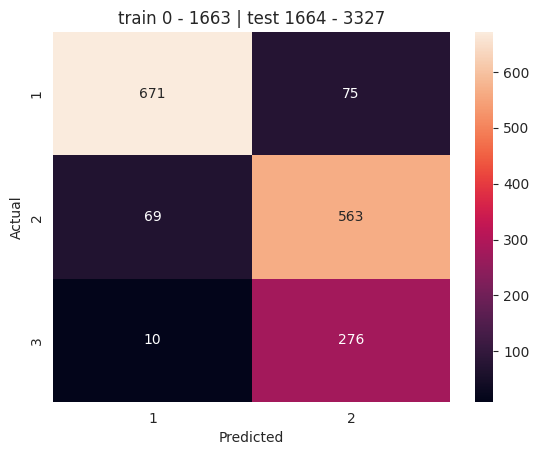

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.89      0.90      0.90       746
           2       0.62      0.89      0.73       632
           3       0.00      0.00      0.00       286

    accuracy                           0.74      1664
   macro avg       0.50      0.60      0.54      1664
weighted avg       0.64      0.74      0.68      1664


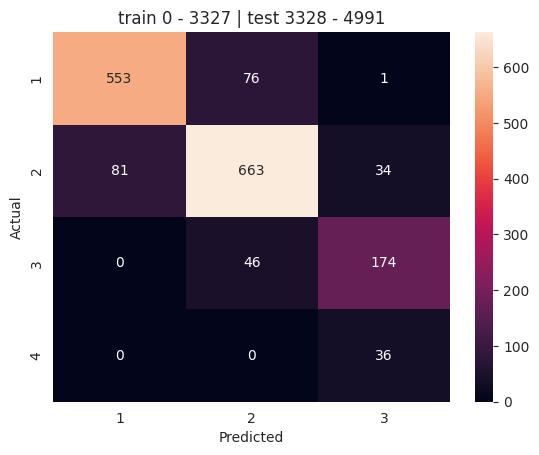

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.87      0.88      0.88       630
           2       0.84      0.85      0.85       778
           3       0.71      0.79      0.75       220
           4       0.00      0.00      0.00        36

    accuracy                           0.84      1664
   macro avg       0.61      0.63      0.62      1664
weighted avg       0.82      0.84      0.83      1664


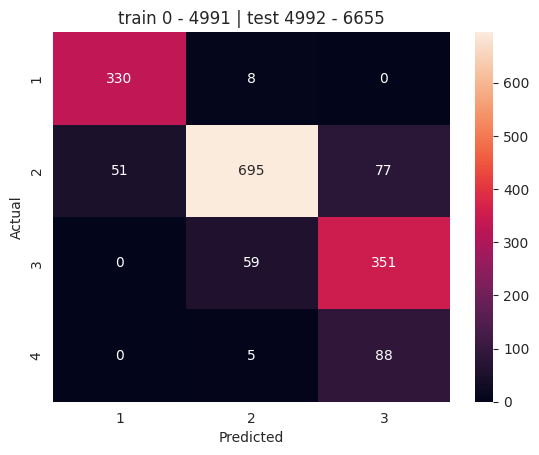

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.87      0.98      0.92       338
           2       0.91      0.84      0.87       823
           3       0.68      0.86      0.76       410
           4       0.00      0.00      0.00        93

    accuracy                           0.83      1664
   macro avg       0.61      0.67      0.64      1664
weighted avg       0.79      0.83      0.81      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


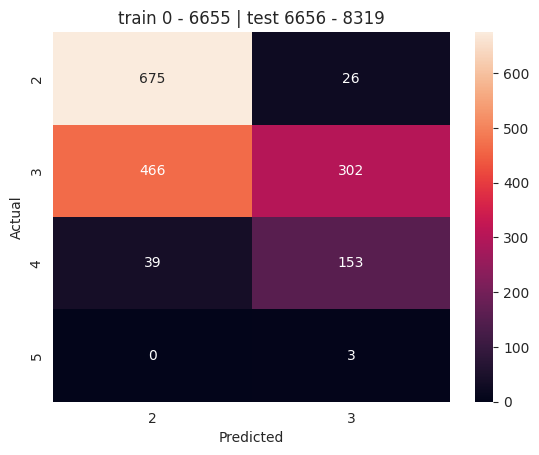

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           2       0.57      0.96      0.72       701
           3       0.62      0.39      0.48       768
           4       0.00      0.00      0.00       192
           5       0.00      0.00      0.00         3

    accuracy                           0.59      1664
   macro avg       0.30      0.34      0.30      1664
weighted avg       0.53      0.59      0.53      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


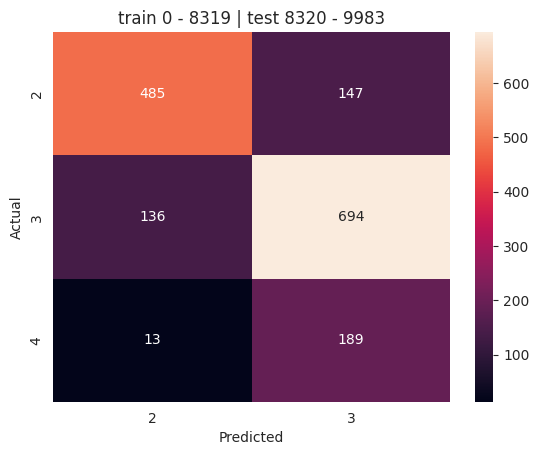

              precision    recall  f1-score   support

           2       0.76      0.77      0.77       632
           3       0.67      0.84      0.75       830
           4       0.00      0.00      0.00       202

    accuracy                           0.71      1664
   macro avg       0.48      0.53      0.50      1664
weighted avg       0.63      0.71      0.66      1664

Mean MSE: 0.285697
Mean R-squared: 0.421418
Mean Accuracy: 0.739904
Accuracy of each set: [0.7415865384615384, 0.8353365384615384, 0.8269230769230769, 0.5871394230769231, 0.7085336538461539]


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

<Figure size 640x480 with 0 Axes>

In [8]:

imputer = SimpleImputer(strategy='mean') 

df_copy = df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
X = df_copy.iloc[:, -14:] # Define explanatory variables
y = df_copy[["ipc"]]  # Define target data
y = y.astype(int)

scaler = StandardScaler()
# Use StratifiedKFold for stratified splitting
cv = TimeSeriesSplit(n_splits=5)

# Initialize empty lists to store scores.6f}"
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    model = LogisticRegression(C=0.01, max_iter=100, penalty='l1', random_state=42, solver='saga')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_values.append(mse)
    r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))
    
print(f"Mean MSE: {np.mean(mse_values):.6f}")
print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

### PREDICTING WITH BINARY MODEL

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [ 6  7  8  9 10 11 12 13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/s

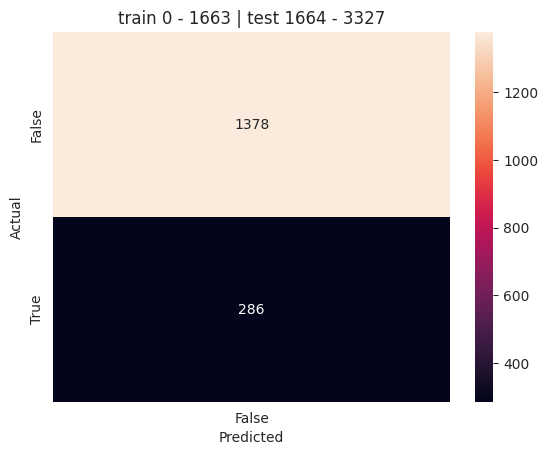

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

       False       0.83      1.00      0.91      1378
        True       0.00      0.00      0.00       286

    accuracy                           0.83      1664
   macro avg       0.41      0.50      0.45      1664
weighted avg       0.69      0.83      0.75      1664


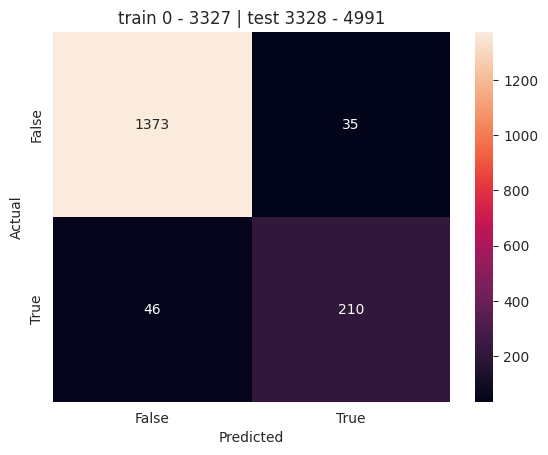

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       False       0.97      0.98      0.97      1408
        True       0.86      0.82      0.84       256

    accuracy                           0.95      1664
   macro avg       0.91      0.90      0.90      1664
weighted avg       0.95      0.95      0.95      1664


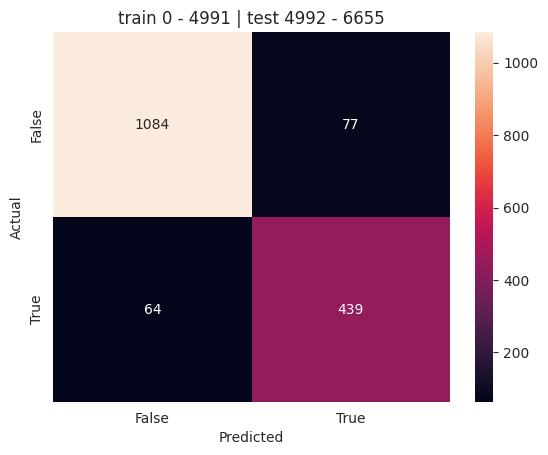

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      1161
        True       0.85      0.87      0.86       503

    accuracy                           0.92      1664
   macro avg       0.90      0.90      0.90      1664
weighted avg       0.92      0.92      0.92      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


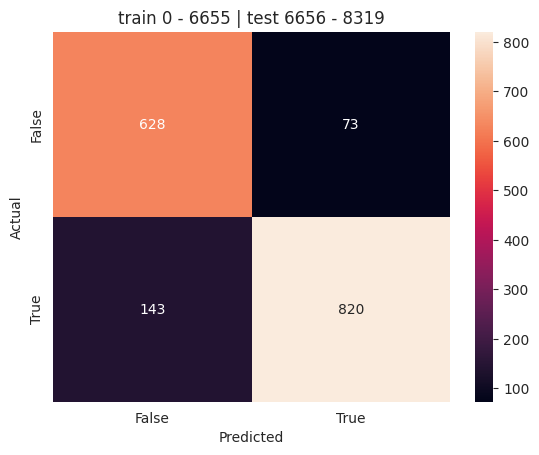

              precision    recall  f1-score   support

       False       0.81      0.90      0.85       701
        True       0.92      0.85      0.88       963

    accuracy                           0.87      1664
   macro avg       0.87      0.87      0.87      1664
weighted avg       0.87      0.87      0.87      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


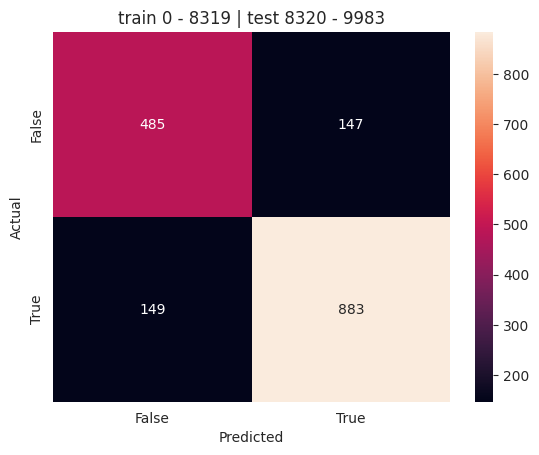

              precision    recall  f1-score   support

       False       0.76      0.77      0.77       632
        True       0.86      0.86      0.86      1032

    accuracy                           0.82      1664
   macro avg       0.81      0.81      0.81      1664
weighted avg       0.82      0.82      0.82      1664

Mean Accuracy: 0.877404
Accuracy of each set: [0.828125, 0.9513221153846154, 0.9152644230769231, 0.8701923076923077, 0.8221153846153846]


<Figure size 640x480 with 0 Axes>

In [11]:

imputer = SimpleImputer(strategy='mean') 

df_copy = df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
X = df_copy.iloc[:, -14:] # Define explanatory variables
y = df_copy[["ipc"]]  # Define target data
y = y.astype(int)

scaler = StandardScaler()
# Use StratifiedKFold for stratified splitting
cv = TimeSeriesSplit(n_splits=5)

# Initialize empty lists to store scores
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float


    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    model = LogisticRegression(C=0.01, max_iter=100, penalty='l1', random_state=42, solver='saga')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)
    
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)
    
    
    # mse = mean_squared_error(y_val, y_pred)
    # r2 = r2_score(y_val, y_pred)

    # mse_values.append(mse)
    # r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix

    print (classification_report(y_val,y_pred))
    
# print(f"Mean MSE: {np.mean(mse_values):.6f}")
# print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

Index(['count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3', 'hunger', 'refugees', 'conflict',
       'humanitarian', 'corruption', 'terrorism', 'nature', 'oil'],
      dtype='object')


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [ 6  7  8  9 10 11 12 13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/s

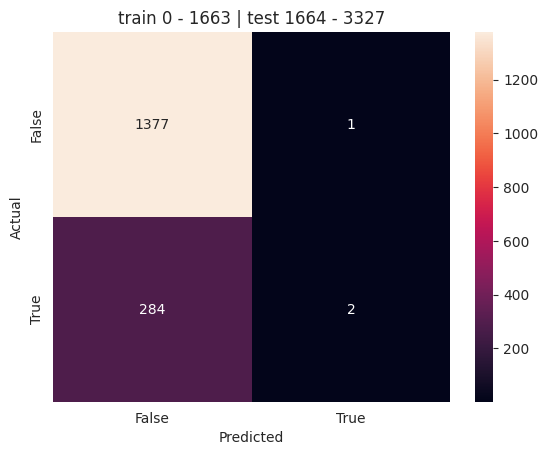

              precision    recall  f1-score   support

       False       0.83      1.00      0.91      1378
        True       0.67      0.01      0.01       286

    accuracy                           0.83      1664
   macro avg       0.75      0.50      0.46      1664
weighted avg       0.80      0.83      0.75      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


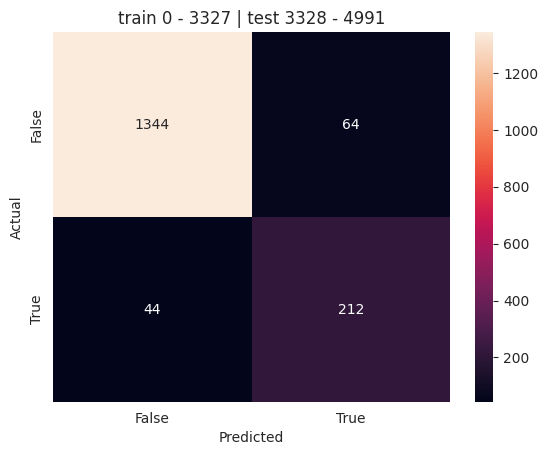

              precision    recall  f1-score   support

       False       0.97      0.95      0.96      1408
        True       0.77      0.83      0.80       256

    accuracy                           0.94      1664
   macro avg       0.87      0.89      0.88      1664
weighted avg       0.94      0.94      0.94      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


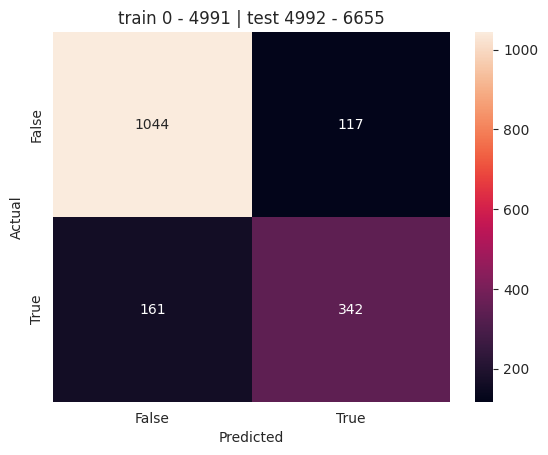

              precision    recall  f1-score   support

       False       0.87      0.90      0.88      1161
        True       0.75      0.68      0.71       503

    accuracy                           0.83      1664
   macro avg       0.81      0.79      0.80      1664
weighted avg       0.83      0.83      0.83      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


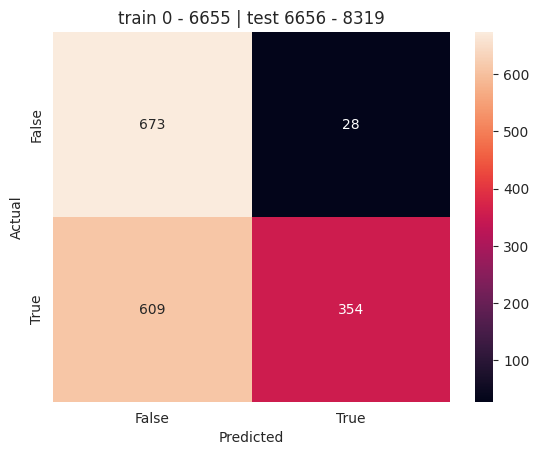

              precision    recall  f1-score   support

       False       0.52      0.96      0.68       701
        True       0.93      0.37      0.53       963

    accuracy                           0.62      1664
   macro avg       0.73      0.66      0.60      1664
weighted avg       0.76      0.62      0.59      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


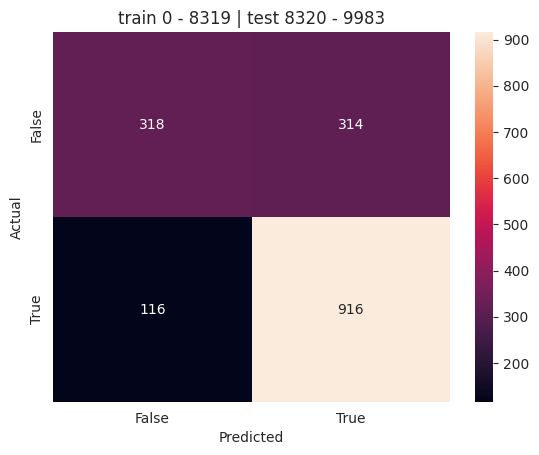

              precision    recall  f1-score   support

       False       0.73      0.50      0.60       632
        True       0.74      0.89      0.81      1032

    accuracy                           0.74      1664
   macro avg       0.74      0.70      0.70      1664
weighted avg       0.74      0.74      0.73      1664

Mean Accuracy: 0.791106
Accuracy of each set: [0.8287259615384616, 0.9350961538461539, 0.8329326923076923, 0.6171875, 0.7415865384615384]


<Figure size 640x480 with 0 Axes>

In [10]:

imputer = SimpleImputer(strategy='mean') 

df_copy = df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
X = df_copy.iloc[:, -14:] # Define explanatory variables
print(X.columns)
y = df_copy[["ipc"]]  # Define target data
y = y.astype(int)

scaler = StandardScaler()
#TimeSeriesSplit splitting
cv = TimeSeriesSplit(n_splits=5)

# Initialize empty lists to store scores
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float


    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    model = LogisticRegression(C=0.01, max_iter=100, penalty='l2', random_state=42, solver='liblinear')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)
    
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)
    
    
    # mse = mean_squared_error(y_val, y_pred)
    # r2 = r2_score(y_val, y_pred)

    # mse_values.append(mse)
    # r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix

    print (classification_report(y_val,y_pred))
    
# print(f"Mean MSE: {np.mean(mse_values):.6f}")
# print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

### TEST OVERFITTING

Index(['food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3', 'hunger',
       'refugees', 'conflict', 'humanitarian', 'corruption', 'terrorism',
       'nature', 'oil', 'constant'],
      dtype='object')


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: [ 4  5  6  7  8  9 10 11]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/s

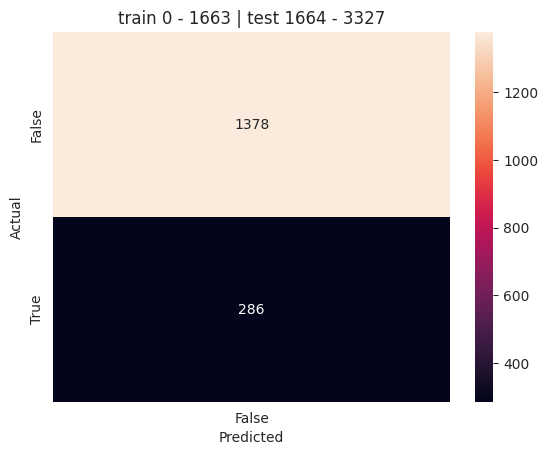

              precision    recall  f1-score   support

       False       0.83      1.00      0.91      1378
        True       0.00      0.00      0.00       286

    accuracy                           0.83      1664
   macro avg       0.41      0.50      0.45      1664
weighted avg       0.69      0.83      0.75      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

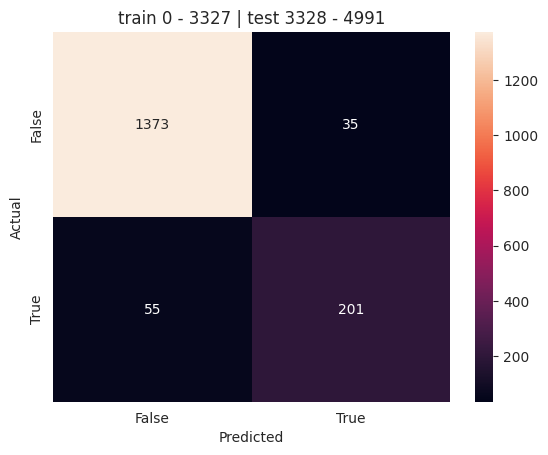

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

       False       0.96      0.98      0.97      1408
        True       0.85      0.79      0.82       256

    accuracy                           0.95      1664
   macro avg       0.91      0.88      0.89      1664
weighted avg       0.94      0.95      0.95      1664


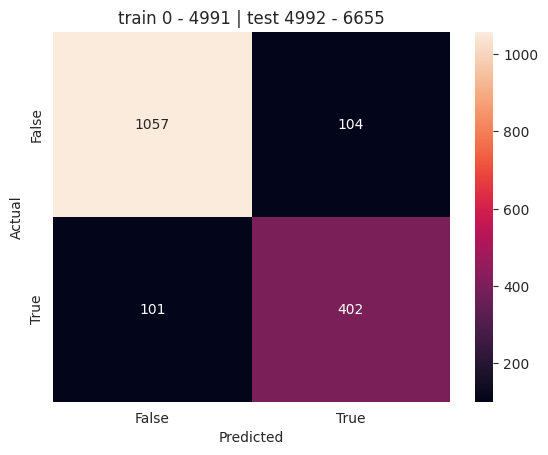

              precision    recall  f1-score   support

       False       0.91      0.91      0.91      1161
        True       0.79      0.80      0.80       503

    accuracy                           0.88      1664
   macro avg       0.85      0.85      0.85      1664
weighted avg       0.88      0.88      0.88      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


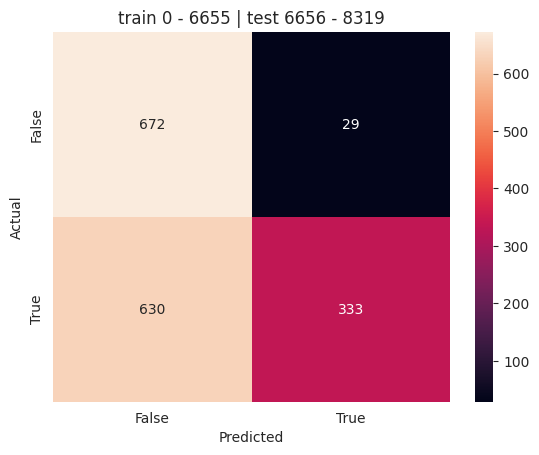

              precision    recall  f1-score   support

       False       0.52      0.96      0.67       701
        True       0.92      0.35      0.50       963

    accuracy                           0.60      1664
   macro avg       0.72      0.65      0.59      1664
weighted avg       0.75      0.60      0.57      1664


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


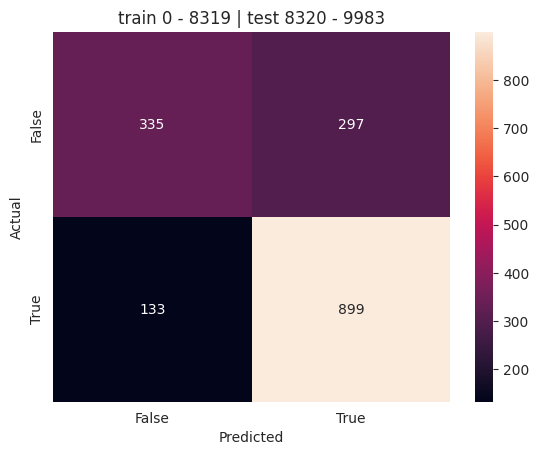

              precision    recall  f1-score   support

       False       0.72      0.53      0.61       632
        True       0.75      0.87      0.81      1032

    accuracy                           0.74      1664
   macro avg       0.73      0.70      0.71      1664
weighted avg       0.74      0.74      0.73      1664

Mean Accuracy: 0.799279
Accuracy of each set: [0.828125, 0.9459134615384616, 0.8768028846153846, 0.6039663461538461, 0.7415865384615384]
Mean Training Accuracy: 0.953598
Mean Validation Accuracy: 0.799279


<Figure size 640x480 with 0 Axes>

In [22]:
from sklearn.metrics import accuracy_score

imputer = SimpleImputer(strategy='mean') 

df_copy = df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
df_copy['constant'] = 1
X = df_copy.iloc[:, -13:] # Define explanatory variables
print(X.columns)
y = df_copy[["ipc"]]  # Define target data
y = y.astype(int)

scaler = StandardScaler()
#TimeSeriesSplit splitting
cv = TimeSeriesSplit(n_splits=5)

# Initialize empty lists to store scores
train_accuracy_values = list()
val_accuracy_values = list()
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    y_binary = y > 2 # Convert y to binary variable
    y_binary[y.isna()] = pd.NA # Conserve NaN values
    y_binary = y_binary.astype("float32") # Convert y to float


    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    model = LogisticRegression(C=0.01, max_iter=100, penalty='l2', random_state=42, solver='liblinear')
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_test)
    
    y_train_pred = y_train_pred.round().astype(bool)
    y_val_pred = y_val_pred.round().astype(bool)
    
    # Calculate accuracy for training and validation sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    train_accuracy_values.append(train_accuracy)
    val_accuracy_values.append(val_accuracy)
    y_pred = model.predict(X_test)
    
    y_pred = y_pred.round().astype(bool)
    y_val = y_val.round().astype(bool)
    
    y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
    y_val.dropna(inplace=True)
    
    
    # mse = mean_squared_error(y_val, y_pred)
    # r2 = r2_score(y_val, y_pred)

    # mse_values.append(mse)
    # r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix

    print (classification_report(y_val,y_pred))
    
    # Calculate accuracy for training and validation sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    train_accuracy_values.append(train_accuracy)
    val_accuracy_values.append(val_accuracy)
    
# print(f"Mean MSE: {np.mean(mse_values):.6f}")
# print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")
print(f"Mean Training Accuracy: {np.mean(train_accuracy_values):.6f}")
print(f"Mean Validation Accuracy: {np.mean(val_accuracy_values):.6f}")



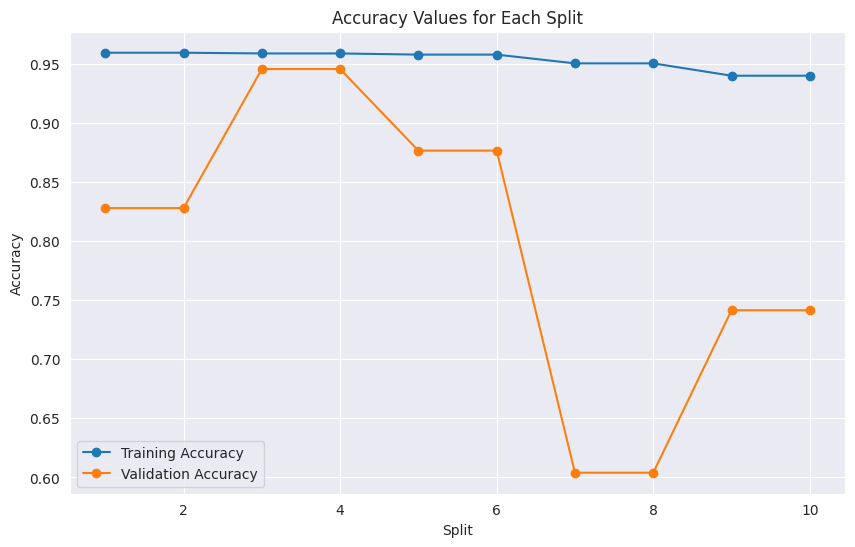

In [23]:
import matplotlib.pyplot as plt

# Plot accuracy values
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy_values) + 1), train_accuracy_values, marker='o', label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_values) + 1), val_accuracy_values, marker='o', label='Validation Accuracy')
plt.xlabel('Split')
plt.ylabel('Accuracy')
plt.title('Accuracy Values for Each Split')
plt.legend()
plt.grid(True)
plt.show()